# Анализ базы вакансий по г. Краснодару с портала Работа России (на 30.12.2022)

Цель работы: исследовать рынок вакансий Краснодара, представленный на портале Работа России (trudvsem.ru).<br>
Задачи:<ul><li>Исследовать уровень предлагаемой заработной платы;</li><li>Изучить распределение вакансий по сферам;</li><li>Выявить различные особенности текущего рынка вакансий.</li></ul>

## Загрузка и предобработка данных

In [1]:
# Загружаем библиотеки
import pandas as pd
import seaborn as sns
import re
import datetime as dt
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import math as mth
from scipy import stats as st

Предварительно до начала этой работы был загружен общий датасет вакансий по России и уменьшен до датасета по г. Краснодару. Загрузим датасет:

In [2]:
# Загружаем датасет
data = pd.read_csv('data_krd.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9116 entries, 0 to 9115
Data columns (total 78 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       9116 non-null   int64  
 1   id                               9116 non-null   object 
 2   academic_degree                  2 non-null      object 
 3   accommodation_capability         9116 non-null   bool   
 4   accommodation_type               6 non-null      object 
 5   additional_premium               102 non-null    float64
 6   additional_requirements          8842 non-null   object 
 7   bonus_type                       100 non-null    object 
 8   measure_type                     100 non-null    object 
 9   busy_type                        9116 non-null   object 
 10  career_perspective               9116 non-null   bool   
 11  change_time                      696 non-null    object 
 12  code_external_system

C:\Users\Vasily\AppData\Local\Temp\ipykernel_11488\2699625864.py:2: DtypeWarning: Columns (2,45,64) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data_krd.csv')


Исходный датасет состоит из 77 колонок и 9116 строк. Большая часть колонок не представляет интереса и несёт скорее технический характер. Удалим некоторые из них:

Удаление ненужных колонок:

In [3]:
data = data.drop(columns = ['academic_degree','code_external_system','foreign_workers_capability','metro_ids','is_mobility_program',\
                            'oknpo_code','okso_code','regionNameTerm','retraining_grant_value',\
                            'industryBranchName','company_name','full_company_name','is_quoted','is_uzbekistan_recruitment',\
                           'contact_source', 'deleted', 'is_moderated', 'need_medcard', 'publication_period',\
                           'regionName','retraining_capability','retraining_condition','federalDistrictCode',\
                           'career_perspective','accommodation_capability','contactList','accommodation_type',\
                            'additional_premium','bonus_type','measure_type',\
                           'career_perspective', 'transport_compensation','visibility'],axis = 1)

In [4]:
# Установка ограничений для Jupiter
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)

Для данного исследования условимся считать среднюю предлагаемую зарплату следующим образом:<br><ul><li>Если максимальная зарплата равна минимальной средняя соответственно равна им;</li><li>Если максимальная больше минимальной, то складываем их и делим на 2.</li></ul>

Напишем функцию расчёта для средней предлагаемой зарплаты и вызовем её:

In [5]:
def get_salary_avg(data):
    if data['salary_max'] < data['salary_min']:
        return data['salary_min']
    elif data['salary_max'] == data['salary_min']:
        return data['salary_max']
    elif data['salary_max'] > data['salary_min']:
        return (data['salary_max'] + data['salary_min'])/2

Вызовем функцию:

In [6]:
data['salary_avg'] = data.apply(get_salary_avg, axis=1)

Ниже представлены первые 10 строк датасета:

In [7]:
display(data.head(10))

,Unnamed: 0,id,additional_requirements,busy_type,change_time,code_profession,code_professional_sphere,company_code,contact_person,data_ids,date_create,date_modify,education,education_speciality,original_source_type,other_vacancy_benefit,position_requirements,position_responsibilities,published_date,company_business_size,required_certificates,required_drive_license,required_experience,retraining_grant,salary,salary_min,salary_max,schedule_type,social_protected_ids,source_type,state_region_code,status,vacancy_address_additional_info,vacancy_address,vacancy_address_code,vacancy_address_house,vacancy_address_latitude,vacancy_address_longitude,vacancy_benefit_ids,vacancy_name,work_places,professionalSphereName,company_inn,company,languageKnowledge,city,salary_avg
0,0,dd748982-c979-11eb-9dd6-bf2cfe8c828d,Шестидневная неделя.<br/>Высоко квалифицирован...,Постоянная занятость,NaN,272509.0,Education,997d0cb0-01c0-11eb-9086-f3e0740405b3,NaN,"[""60a9f3c0-7087-11ed-8384-93f7cc862eb6"",""60a9f...",2022-08-30T14:41:40+0300,2022-11-30T11:17:06+0300,Высшее,NaN,EMPLOYMENT_SERVICE,Социальный пакет,Добросовестное исполнение возложенных обязанно...,- Учитель выполняет следующие должностные обяз...,2022-11-25T00:00:00+0300,SMALL,NaN,[],0.0,нет стипендии,от 20000,20000.0,22000.0,Полный рабочий день,NaN,Вакансия службы занятости,2300000000000,ACCEPTED,"350047, г Краснодар, ул Темрюкская, д. 68, При...",NaN,2300000000000,NaN,43.430428,39.928983,NaN,Учитель-логопед,1,"Образование, наука",2.311061e+09,"{""ogrn"":""1032306427306"",""companycode"":""997d0cb...",[],г Краснодар,21000.0
1,6,79a94e72-f31e-11ec-9330-bf2cfe8c828d,Промышленное и гражданское строительство<br/>Д...,Постоянная занятость,NaN,NaN,Industry,1182375034555,Власенко Светлана Валерьевна,"[""df909b60-7089-11ed-8384-93f7cc862eb6"",""df909...",2022-08-30T15:06:25+0300,2022-11-30T11:34:58+0300,Высшее,NaN,EMPLOYMENT_SERVICE,Социальный пакет,высшее профильное образование (ПГС) или технич...,"составление и проверка КС-2,КС-3; проверка сме...",2022-11-23T00:00:00+0300,SMALL,NaN,[],5.0,нет стипендии,от 60000,60000.0,70000.0,Полный рабочий день,NaN,Вакансия службы занятости,2300000000000,ACCEPTED,"350910, г Краснодар, ул им Фадеева, д. 214, оф...",NaN,2300000000000,NaN,45.021042,39.107985,NaN,Инженер по сметно-договорной работе,1,Производство,2.312271e+09,"{""ogrn"":""1182375034555"",""companycode"":""1182375...",[],г Краснодар,65000.0
2,10,b5121272-aad1-11ec-9aad-bf2cfe8c828d,Ответственность,Постоянная занятость,NaN,254163.0,Jurisprudence,1102312001043,Грушко Виктория Владимировна,"[""39602cc0-0ac6-11ed-88f6-bf2cfe8c828d"",""39602...",2022-03-23T20:50:20+0300,2022-11-14T19:51:19+0300,Среднее,NaN,EMPLOYMENT_SERVICE,Социальный пакет,"Иметь удостоверение охранника 4 разряда , отве...","Охрана объектов , добросовестное выполнение св...",2022-06-24T00:00:00+0300,SMALL,NaN,[],0.0,нет стипендии,от 17400,17400.0,17400.0,Сменный график,NaN,Вакансия службы занятости,2300000000000,ACCEPTED,"350001, г Краснодар, ул Новороссийская, д. 2А",NaN,2300000000000,NaN,45.022208,39.000852,NaN,Охранник 4 категории (класса),1,Юриспруденция,2.312169e+09,"{""ogrn"":""1102312001043"",""companycode"":""1102312...",[],г Краснодар,17400.0
3,11,431bb182-c51b-11ec-9aad-bf2cfe8c828d,"""Химия"", ""Астрономия""<br/>Ответственность",Постоянная занятость,NaN,258126.0,Education,1022301195465,Романова Елена Васильевна,"[""2ac5e500-5171-11ed-a1ff-93f7cc862eb6"",""2ac5e...",2022-08-30T14:56:13+0300,2022-11-29T16:34:42+0300,Высшее,NaN,EMPLOYMENT_SERVICE,Здравохранение<br/>Льготная пенсия<br/>Социаль...,Опыт работы в области профессиональной деятель...,"Проводить занятия со студентами, составлять КТ...",2022-09-22T00:00:00+0300,SMALL,NaN,[],1.0,нет стипендии,от 20000,20000.0,40000.0,Полный рабочий день,NaN,Вакансия службы занятости,2300000000000,ACCEPTED,"350075, г Краснодар, ул им Стасова, д. 182, ко...",NaN,2300000000000,NaN,45.026546,39.046253,NaN,"Преподаватель (в колледжах, университетах и др...",1,"Образование, наука",2.308080e+09,"{

## Исследовательский анализ

### Распределение вакансий в зависимости от предлагаемой зарплаты

30000.0    580
16043.0    500
25000.0    482
40000.0    434
15279.0    418
20000.0    404
35000.0    372
50000.0    208
16500.0    198
22500.0    182
Name: salary_avg, dtype: int64

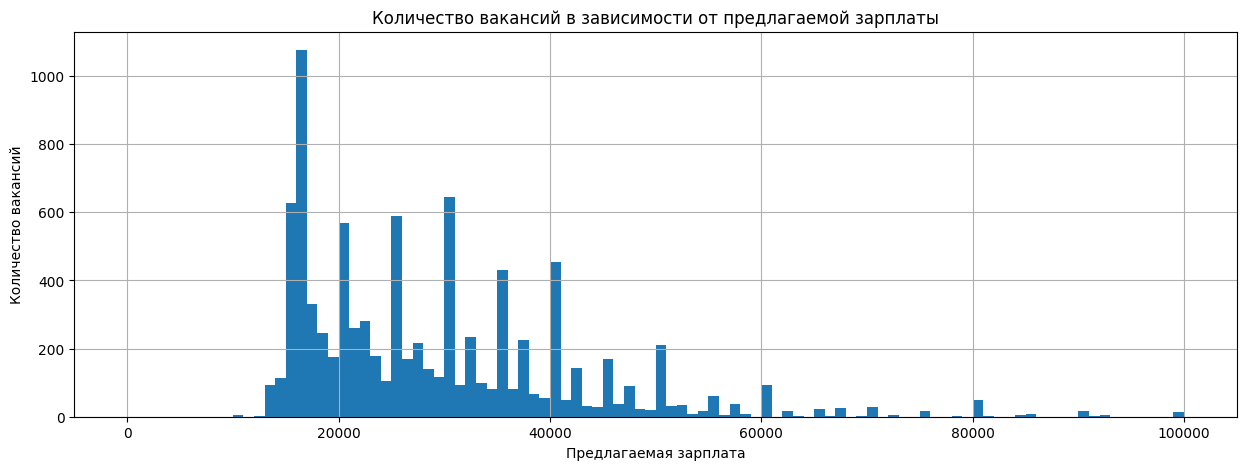

In [8]:
display(data['salary_avg'].value_counts().head(10))

plt.figure(figsize=(15,5))
ax = plt.hist(data['salary_avg'], bins = 100, range = (0, 100000))
plt.title('Количество вакансий в зависимости от предлагаемой зарплаты')
plt.ylabel('Количество вакансий')
plt.xlabel('Предлагаемая зарплата')
plt.grid()
plt.show()

На гистограмме выше видно, что имеются "пики" вокруг значений зарплаты, кратной 5 (например, 20000, 25000, 30000).
Отдельно стоит выделить большое количество вакансий с минимально предлагаемыми зарплатами в размере 15279 и 16043 рублей.
Это неслучайно - дело в том, что 15279 рублей - это МРОТ в Краснодарском Крае за полный рабочий месяц, а 16043 рублей - МРОТ для небюджетных организаций, установленный региональным соглашением о МРОТ от от 30.12.2021 г.

Выведем график с "сглаживанием":

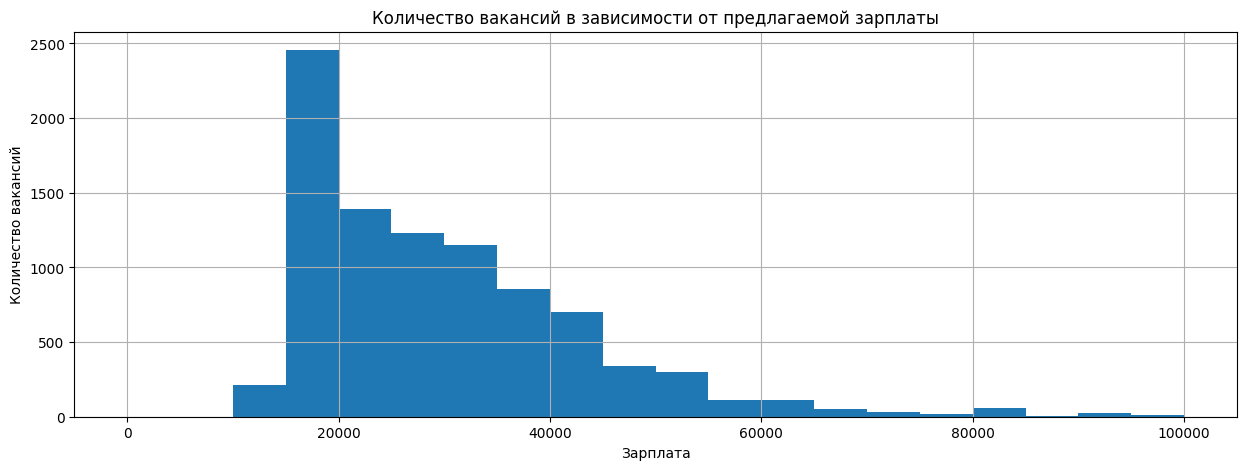

In [9]:
plt.figure(figsize=(15,5))
ax = plt.hist(data['salary_avg'], bins = 20, range = (0, 100000))
plt.title('Количество вакансий в зависимости от предлагаемой зарплаты')
plt.ylabel('Количество вакансий')
plt.xlabel('Зарплата')
plt.grid()
plt.show()

На гистограмме хорошо видно "моду" - начало диапазона вилки зарплаты, которая встречается чаще всего: это 15000-19999 рублей.

###  Количество вакансий в разрезе названия вакансий

Найдём "часто встречаемые" вакансии:

In [10]:
freq_vacancy_name = data.groupby('vacancy_name', as_index = False).agg({'id': 'count'})\
                                .sort_values(by='id', ascending=False)

display(freq_vacancy_name.head(10).reset_index(drop=True))

,vacancy_name,id
0,Уборщик производственных и служебных помещений,384
1,Бухгалтер,246
2,Водитель автомобиля,206
3,Специалист,204
4,Младший воспитатель,162
5,Повар,148
6,"Преподаватель (в колледжах, университетах и др...",132
7,Грузчик,130
8,Дворник,124
9,Фармацевт,118


Выше в таблице представлены частовстречаемые названия вакансий. Ниже отобразим долю первых восьми частовстречаемых вакансий от всех остальных:

C:\Users\Vasily\AppData\Local\Temp\ipykernel_11488\2162576303.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freq_vacancy_name_mod.loc[len(freq_vacancy_name_mod.index)] = ['Остальные', oher_freq_s]


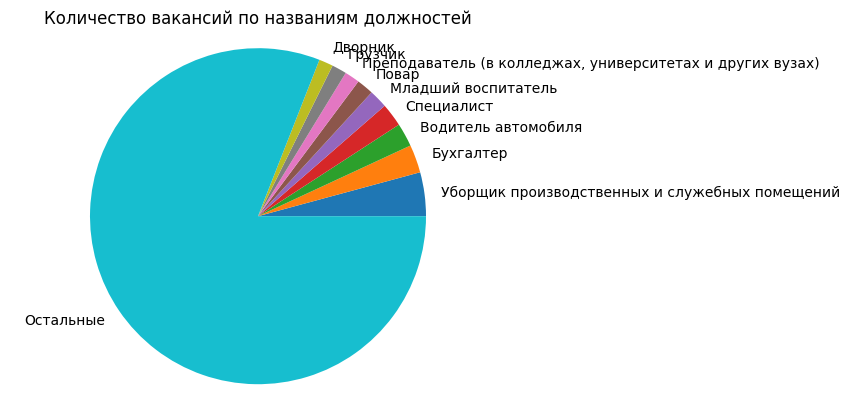

In [11]:
freq_vacancy_name_m = freq_vacancy_name.query('id < 124')
oher_freq_s = freq_vacancy_name_m['id'].sum()

oher_freq = pd.DataFrame({'vacancy_name': 'Остальные', 'id': oher_freq_s}, index=[0])
freq_vacancy_name_mod = freq_vacancy_name.query('id >= 124')
freq_vacancy_name_mod.reset_index(drop=True, inplace=True)

freq_vacancy_name_mod.loc[len(freq_vacancy_name_mod.index)] = ['Остальные', oher_freq_s]


vals = freq_vacancy_name_mod['id']
labels = freq_vacancy_name_mod['vacancy_name']
fig, ax = plt.subplots()
ax.pie(vals, labels=labels)
plt.title('Количество вакансий по названиям должностей')
ax.axis("equal");

Менее четверти диагаммы занимают 8 наиболее популярных названий вакансий.

### Количество вакансий в разрезе сфер деятельности

Рассмотрим долю вакансий в зависимости от сферы деятельности:

In [12]:
sphere = data.groupby('professionalSphereName', as_index=False)\
    .agg({'id': 'count', 'salary_avg': 'mean'}).rename(columns={'id':'id_count'})\
    .sort_values(by='id_count',ascending=False)
sphere.reset_index(drop=True, inplace=True)
display(sphere.head(10))
sphere_for_barh = sphere.head(10)
sphere_for_barh = sphere_for_barh.sort_values(by='id_count',ascending=True)

,professionalSphereName,id_count,salary_avg
0,Производство,2638,28464.424943
1,"Образование, наука",1456,22002.157280
2,Здравоохранение и социальное обеспечение,904,30938.961283
3,"Консалтинг, стратегическое развитие, управление",768,32219.824219
4,"Продажи, закупки, снабжение, торговля",544,30174.854779
5,"Строительство, ремонт, стройматериалы, недвижи...",486,38715.275720
6,Пищевая промышленность,470,21521.423404
7,"Транспорт, автобизнес, логистика, склад, ВЭД",410,35600.958333
8,"Банки, кредит, страхование, пенсионное обеспеч...",276,35045.942029
9,"ЖКХ, эксплуатация",244,28089.721311


Больше всего вакансий предлагается в следующих сферах: производство (2638 вакансий), образование и наука (1456), здравохранение и социальное обеспечение (904) 

Отобразим распределение вакансий по сферам деятельности на круговой диаграмме:

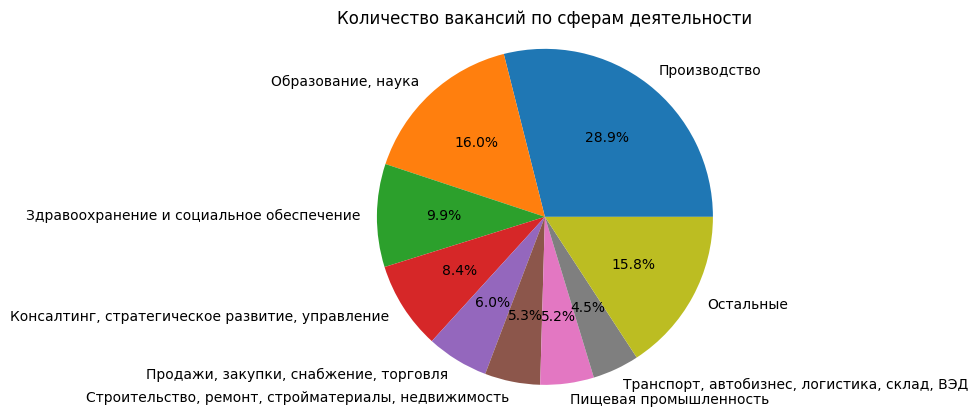

In [13]:
freq_sphere_name_m = sphere.query('id_count < 410')
oher_freq_sphere_s = freq_sphere_name_m['id_count'].sum()

oher_freq_sphere = pd.DataFrame({'professionalSphereName': 'Остальные', 'id_count': oher_freq_sphere_s}, index=[0])

freq_oher_freq_sphere_name_mod = sphere.query('id_count >= 410')
freq_oher_freq_sphere_name_mod.reset_index(drop=True, inplace=True)

freq_oher_freq_sphere_name_mod = freq_oher_freq_sphere_name_mod.drop(columns = ['salary_avg'], axis = 1)

freq_oher_freq_sphere_name_mod.loc[len(freq_oher_freq_sphere_name_mod.index)] = ['Остальные', oher_freq_sphere_s]

vals = freq_oher_freq_sphere_name_mod['id_count']
labels = freq_oher_freq_sphere_name_mod['professionalSphereName']
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%')
plt.title('Количество вакансий по сферам деятельности')
ax.axis("equal");

Абсолютное большинство вакансий приходится на сферу производства, образования и науки, здравохранения и социального обеспечения - 54,8% вакансий от всех вакансий.

### Предлагаемая средняя зарплата по сферам деятельности

Выведем диаграмму размаха топ-10 сфер деятельности по медианной предлагаемой зарплате:

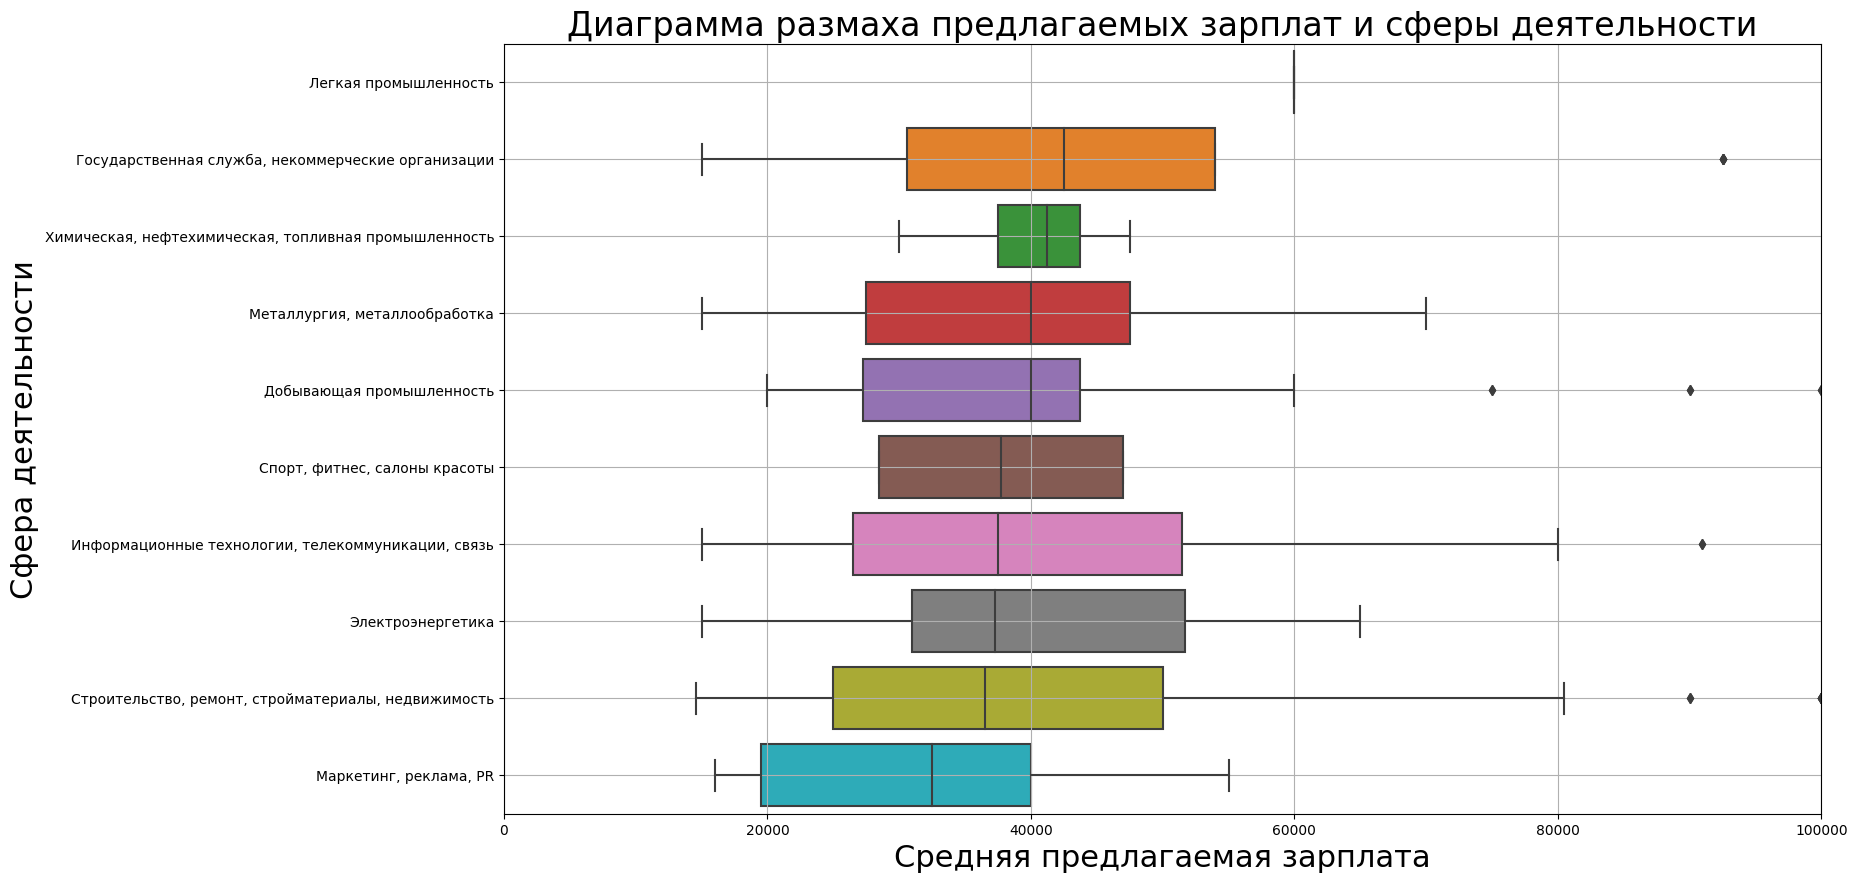

In [14]:
grouped_sphere_median = data.loc[:,['professionalSphereName', 'salary_avg']] \
    .groupby(['professionalSphereName']) \
    .median() \
    .sort_values(by='salary_avg', ascending=False)
grouped_sphere_median = grouped_sphere_median.head(10)

ax = plt.figure(figsize=(17,10))
ax = sns.boxplot(x='salary_avg', y='professionalSphereName', data = data, order=grouped_sphere_median.index)
ax = plt.xlim(0, 100000)
plt.title("Диаграмма размаха предлагаемых зарплат и сферы деятельности", fontsize = 24)
plt.xlabel('Средняя предлагаемая зарплата', fontsize=22)
plt.ylabel('Сфера деятельности', fontsize=22)
plt.grid()

plt.show();

Первое место занимает лёгкая промышленность, однако всего вакансий 4. Целесообразно не учитывать те сферы, где количество вакансий незначительно.

Отобразим данные в табличном виде и создадим дополнительную диаграмму топ-10 сфер деятельности по предлагаемой зарплате (не учитывая сферы с мнее 25 вакансиями):

In [15]:
sphere_for_sal = sphere.sort_values(by='salary_avg',ascending=True).reset_index(drop=True)
sphere_for_sal = sphere_for_sal.query('id_count >= 25')

display(sphere_for_sal.tail(10).sort_values(by='salary_avg',ascending=False).reset_index(drop=True))

,professionalSphereName,id_count,salary_avg
0,"Государственная служба, некоммерческие организ...",54,57811.407407
1,"Информационные технологии, телекоммуникации, с...",170,44523.200000
2,Добывающая промышленность,46,42618.326087
3,"Металлургия, металлообработка",58,39432.517241
4,"Строительство, ремонт, стройматериалы, недвижи...",486,38715.275720
5,Электроэнергетика,26,38087.500000
6,"Транспорт, автобизнес, логистика, склад, ВЭД",410,35600.958333
7,"Банки, кредит, страхование, пенсионное обеспеч...",276,35045.942029
8,"Консалтинг, стратегическое развитие, управление",768,32219.824219
9,"Лесная, деревообрабатывающая, целлюлозно-бумаж...",34,31009.676471


Отобразим результаты исследования на диаграмме:

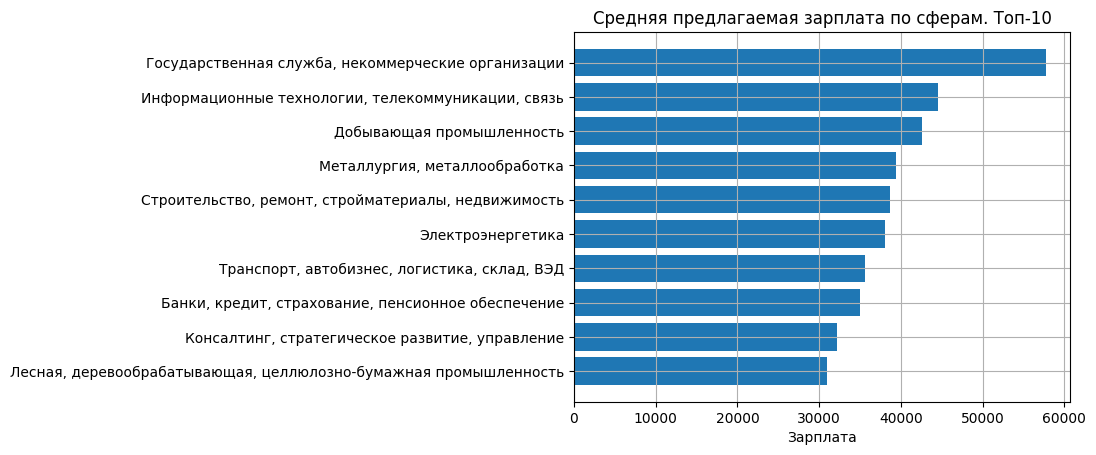

In [16]:
sphere_for_sal_m = sphere.sort_values(by='salary_avg',ascending=True)
sphere_for_sal_m = sphere_for_sal_m.query('id_count >= 25')
sphere_for_sal_bot = sphere_for_sal.head(5)
sphere_for_sal_top = sphere_for_sal.tail(10)

fig, ax = plt.subplots()
ax.barh(sphere_for_sal_top['professionalSphereName'], sphere_for_sal_top['salary_avg'])
plt.title('Средняя предлагаемая зарплата по сферам. Топ-10')
plt.xlabel('Зарплата')
ax.grid()
plt.show()

### Средняя предлагаемая зарплата по сферам. Антитоп-5.

Сделаем аналогичные расчёты для антитопа. Найдём 5 сфер с наименьшей средней оплатой:

In [17]:
display(sphere_for_sal_m.head(5).sort_values(by='salary_avg',ascending=False).reset_index(drop=True))

,professionalSphereName,id_count,salary_avg
0,"ЖКХ, эксплуатация",244,28089.721311
1,Юриспруденция,190,26445.115789
2,"Искусство, культура и развлечения",160,26149.956250
3,"Образование, наука",1456,22002.157280
4,Пищевая промышленность,470,21521.423404


Отобразим табличную информацию в виде диаграммы:

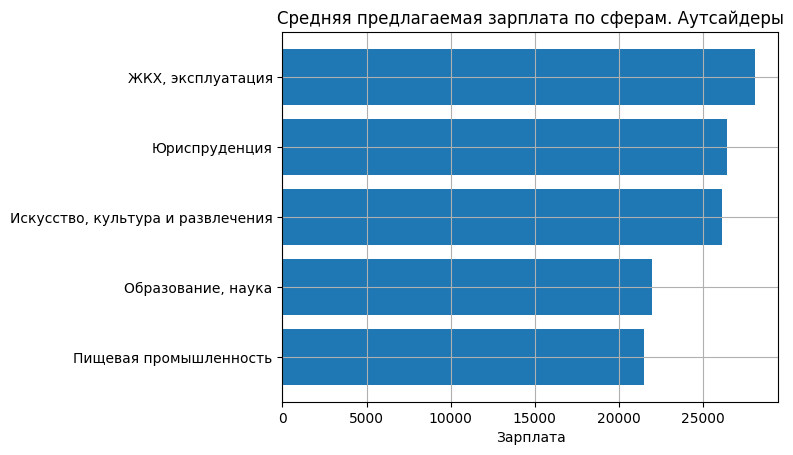

In [18]:
fig, ax = plt.subplots()
ax.barh(sphere_for_sal_bot['professionalSphereName'], sphere_for_sal_bot['salary_avg'])
plt.title('Средняя предлагаемая зарплата по сферам. Аутсайдеры')
plt.xlabel('Зарплата')
ax.grid()
plt.show()

Меньше всего средняя предлагаемая зарплата в таких сферах как ЖКХ, эксплуатация (28089 руб.), Юриспруденция (26445 руб.) ,
Искусство, культура и развлечения (26149 руб.),
Образование, наука (22002 руб.),
Пищевая промышленность (21521 руб.).

###  Средние предлагаемые зарплаты наиболее распространённых профессий

Посмотрим на средние предлагаемые зарплаты наиболее часто встречающихся названий вакансий:

In [19]:
vacan = data.groupby('vacancy_name', as_index=False).agg({'id': 'count', 'salary_avg': 'mean'})\
    .rename(columns={'id':'id_count'})\
    .sort_values(by='id_count',ascending=False)
vac = vacan.head(10)
vac = vac.sort_values(by='id_count',ascending=True)
vac_s = vacan.head(10)
vac_s = vac_s.sort_values(by='salary_avg',ascending=True)
print(vac)

                                           vacancy_name  id_count  \
1012                                          Фармацевт       118   
229                                             Дворник       124   
227                                             Грузчик       130   
704   Преподаватель (в колледжах, университетах и др...       132   
652                                               Повар       148   
514                                 Младший воспитатель       162   
835                                          Специалист       204   
101                                 Водитель автомобиля       206   
49                                            Бухгалтер       246   
962      Уборщик производственных и служебных помещений       384   

        salary_avg  
1012  21545.652542  
229   17335.120968  
227   28771.876923  
704   22101.954545  
652   20817.310811  
514   16070.141975  
835   27271.617647  
101   34386.587379  
49    30607.906504  
962   18428.083333  


Визуализируем это на диаграмме:

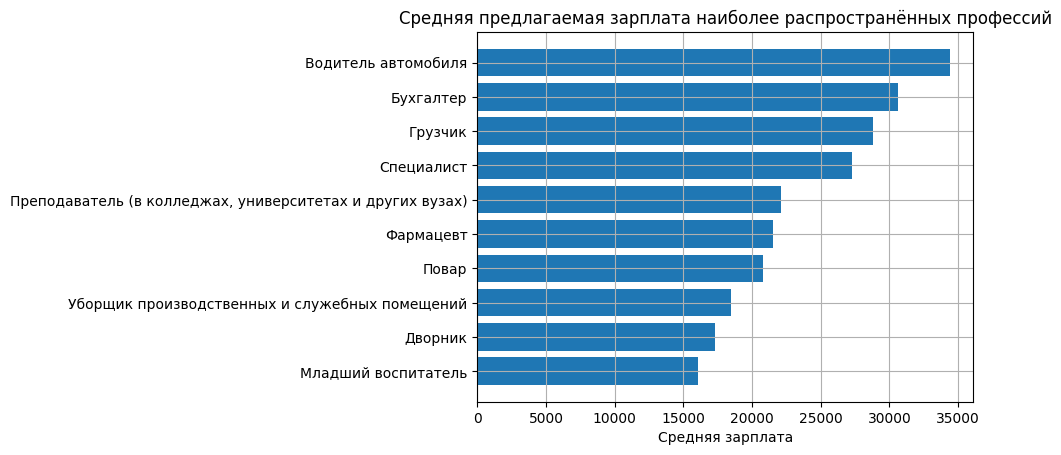

In [20]:
fig, ax = plt.subplots()
ax.barh(vac_s['vacancy_name'], vac_s['salary_avg'])
plt.title('Средняя предлагаемая зарплата наиболее распространённых профессий')
plt.xlabel('Средняя зарплата')
ax.grid()
plt.show()

Для соискателей на должность Водитель автомобиля средняя предлагаемая зарплата составляет почти 35000 рублей (34386). Бухгалтер может рассчитывать на среднюю предлагаемую зарплату при поиске работы 30607 рублей), грузчик 28771 руб.

### Распределение вакансий в зависимости от требуемого опыта

Посмотрим на количество вакансий в зависимости от требуемого опыта. Рассмотрим требуемый опыт от его отсутствия (0) до наличия опыта не менее 5 лет:

In [21]:
vacan_exp = data.groupby('required_experience', as_index=False).agg({'id': 'count', 'salary_avg': 'mean'})\
    .rename(columns={'id':'id_count'})\
    .sort_values(by='id_count',ascending=False)
vacan_exp = vacan_exp.query('required_experience < 6 and required_experience >= 0')
vac_exp = vacan_exp.head(10)
vac_exp = vac_exp.sort_values(by='id_count',ascending=True)
vac_s_exp = vacan_exp.head(10)
vac_s_exp = vac_s.sort_values(by='salary_avg',ascending=True)

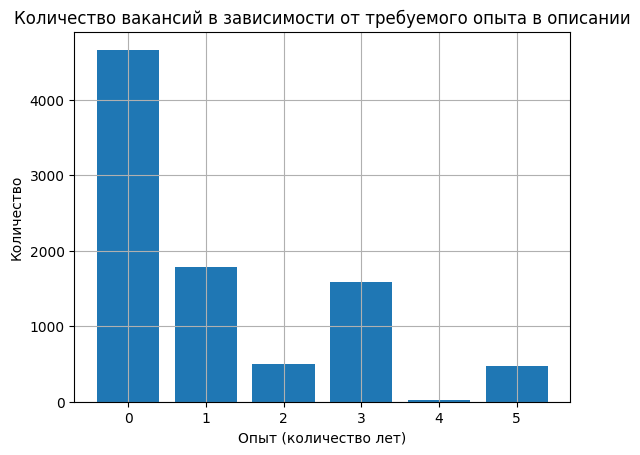

In [22]:
fig, ax = plt.subplots()

ax.bar(vac_exp['required_experience'], vac_exp['id_count'])
ax.grid()
plt.title('Количество вакансий в зависимости от требуемого опыта в описании')
plt.ylabel('Количество')
plt.xlabel('Опыт (количество лет)')
plt.show()

Построим круговую диаграмму:

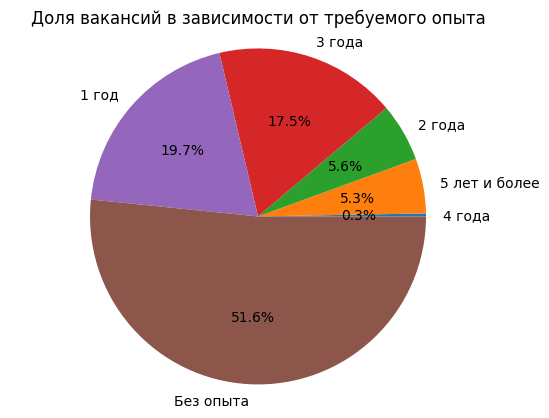

In [23]:
data_names = ["4 года", "5 лет и более", 
"2 года", "3 года", "1 год", 'Без опыта']
vals = vac_exp['id_count']
labels = vac_exp['required_experience']
fig, ax = plt.subplots()
ax.pie(vals, labels=data_names, autopct='%1.1f%%')
plt.title('Доля вакансий в зависимости от требуемого опыта')
ax.axis("equal");

Абсолютное большинство предлагаемых вакансий (51,8%) не требуют опыта работы.

### Предлагаемые вакансии в зависимости от опыта работы в описании:

Посмотрим предлагаемую среднюю заработную в сферах для соискателей без опыта работы:

                               professionalSphereName  id_count    salary_avg
15                                 Образование, наука       928  20395.439655
27                                      Юриспруденция        92  20602.858696
16                             Пищевая промышленность       280  21285.710714
18                                       Производство      1430  24613.123776
11    Консалтинг, стратегическое развитие, управление       254  25707.771654
7                                   ЖКХ, эксплуатация       122  26772.901639
8            Здравоохранение и социальное обеспечение       538  28535.126394
17              Продажи, закупки, снабжение, торговля       306  28963.754902
23       Транспорт, автобизнес, логистика, склад, ВЭД       170  29938.582353
22  Строительство, ремонт, стройматериалы, недвижи...       176  34305.420455


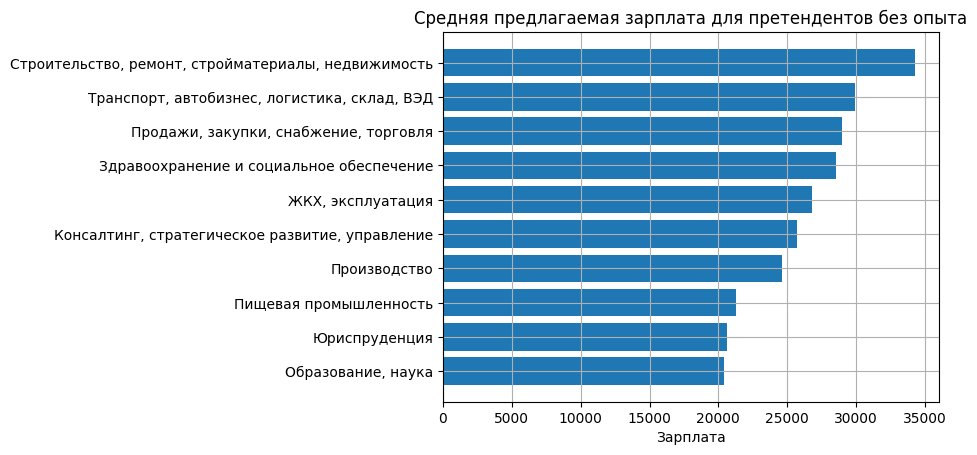

In [24]:
data_exp_null = data.query('required_experience == 0')
data_exp_null = data_exp_null.query('salary_avg > 0')
sphere_null = data_exp_null.groupby('professionalSphereName', as_index=False).agg({'id': 'count', 'salary_avg': 'mean'}).rename(columns={'id':'id_count'})\
    .sort_values(by='id_count',ascending=False)

sphere_null = sphere_null.sort_values(by='id_count',ascending=False)
sphere_for_sal = sphere_null.head(10)
sphere_for_sal = sphere_for_sal.sort_values(by='salary_avg',ascending=True)

data_246_users = data_exp_null['id'].nunique()
print(sphere_for_sal)

fig, ax = plt.subplots()

ax.barh(sphere_for_sal['professionalSphereName'], sphere_for_sal['salary_avg'])
plt.title('Средняя предлагаемая зарплата для претендентов без опыта')
plt.xlabel('Зарплата')
ax.grid()
plt.show()

Наибольшая оплата для соискателей без опыта работы предлагается в сфере строительства - почти 35000 рублей. Следом идут транспорт и сфера продаж.

### Предлагаемая зарплата для кандидатов с опытом от 1 года

Составим аналогичный рейтинг, только с требуемым опытом от 1 года:

                               professionalSphereName  id_count    salary_avg
14                             Пищевая промышленность       122  21747.311475
13                                 Образование, наука       298  23850.969799
5                                   ЖКХ, эксплуатация        40  27638.200000
9     Консалтинг, стратегическое развитие, управление       116  28633.258621
16                                       Производство       478  31147.790795
15              Продажи, закупки, снабжение, торговля        96  31198.541667
0   Банки, кредит, страхование, пенсионное обеспеч...        84  33864.285714
6            Здравоохранение и социальное обеспечение       198  35047.030303
19  Строительство, ремонт, стройматериалы, недвижи...       100  38984.360000
20       Транспорт, автобизнес, логистика, склад, ВЭД        76  43090.394737


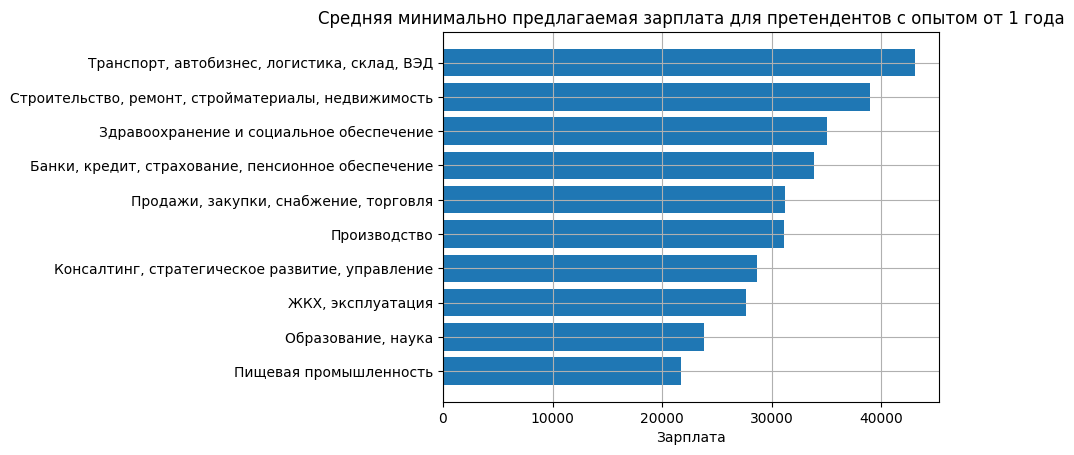

In [25]:
data_exp_1 = data.query('required_experience == 1')
data_exp_1 = data_exp_1.query('salary_avg > 0')
sphere_exp = data_exp_1.groupby('professionalSphereName', as_index=False)\
    .agg({'id': 'count', 'salary_avg': 'mean'}).rename(columns={'id':'id_count'})\
    .sort_values(by='id_count',ascending=False)

sphere_exp = sphere_exp.sort_values(by='id_count',ascending=False)
sphere_for_exp = sphere_exp.head(10)
sphere_for_exp = sphere_for_exp.sort_values(by='salary_avg',ascending=True)

print(sphere_for_exp)
data_exp_1['salary_avg'] = data_exp_1['salary_avg'].astype('int')
data_exp_null['salary_avg'] = data_exp_null['salary_avg'].astype('int')
data_247_users = data_exp_1['id'].nunique()

fig, ax = plt.subplots()

ax.barh(sphere_for_exp['professionalSphereName'], sphere_for_exp['salary_avg'])
plt.title('Средняя минимально предлагаемая зарплата для претендентов с опытом от 1 года')
plt.xlabel('Зарплата')
ax.grid()
plt.show()

Наибольшая средняя предлагаемая зарплата для соискателей с опытом работы приходится на сферы Транспорта и логистики (43090 рублей) и Строительства (почти 39000 рублей).

### Количество вакансий в зависимости от типа занятости

Рассмотрим распределение вакансий в зависимости от типа занятости:

In [26]:
type_busy = data.groupby('busy_type', as_index=False).agg({'id': 'count', 'salary_avg': 'mean'}).rename(columns={'id':'id_count'})\
    .sort_values(by='id_count',ascending=False)

In [27]:
type_busy = type_busy.sort_values(by='salary_avg',ascending=True)
type_busy = type_busy.query('id_count > 100')
type_busy_top = type_busy.tail(4)

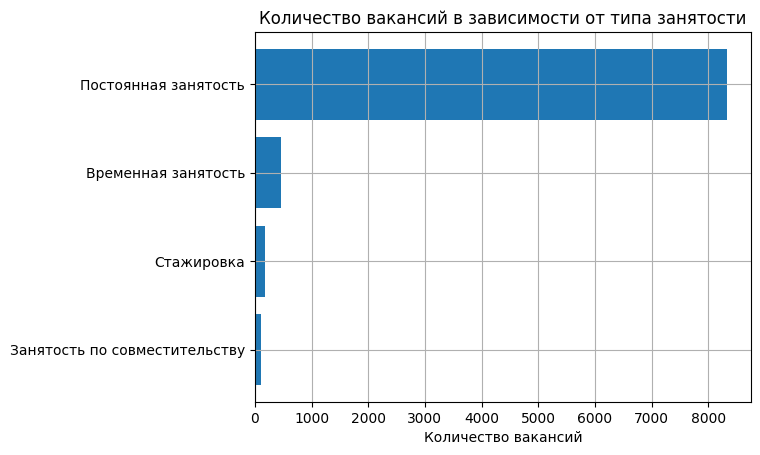

In [28]:
fig, ax = plt.subplots()
ax.barh(type_busy_top['busy_type'], type_busy_top['id_count'])
plt.title('Количество вакансий в зависимости от типа занятости')
plt.xlabel('Количество вакансий')
ax.grid()
plt.show()

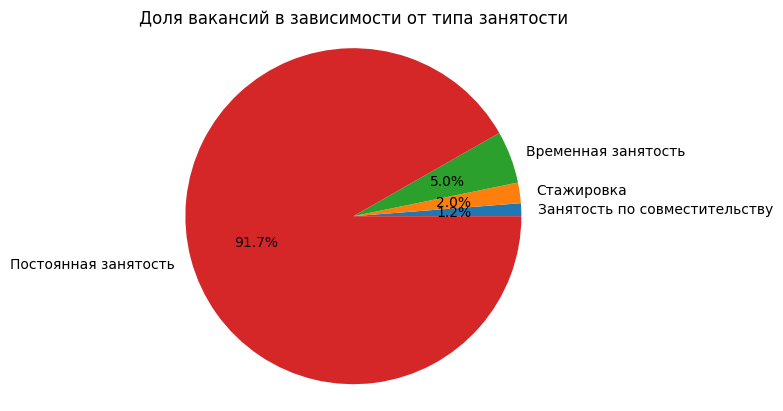

In [29]:
vals = type_busy_top['id_count']
labels = type_busy_top['busy_type']
fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%')
plt.title('Доля вакансий в зависимости от типа занятости')
ax.axis("equal");

Абсолютное большинство (91.7%) составляют вакансии предполагающие постоянную занятость.

### Средняя минимальная зарплата в зависимости от типа занятости

Посмотрим на предлагаемую среднюю зарплату при различных типах занятости:

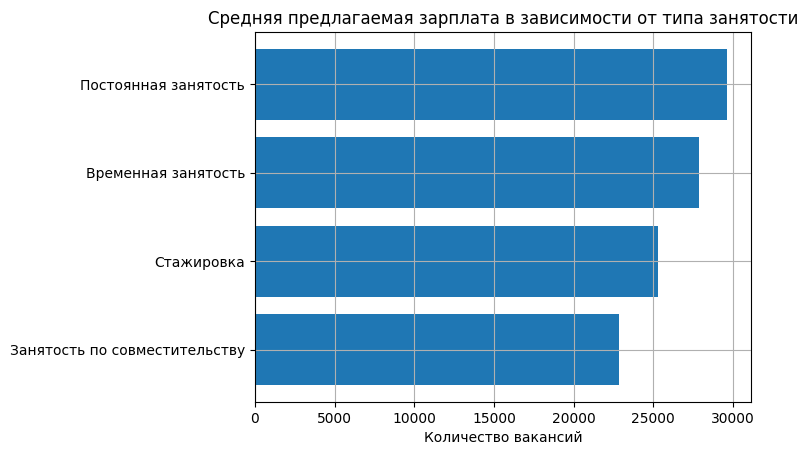

In [30]:
fig, ax = plt.subplots()
ax.barh(type_busy_top['busy_type'], type_busy_top['salary_avg'])
plt.title('Средняя предлагаемая зарплата в зависимости от типа занятости')
plt.xlabel('Количество вакансий')
ax.grid()
plt.show()

Самая высокая средняя зарплата при постоянной занятости, почти 30000 рублей.

### Средняя предлагаемая зарплата в вакансиях с требованием определённого уровня образования

,education,id_count,salary_avg
0,Высшее,3696,33506.895236
3,Среднее профессиональное,3408,27937.222124
2,Среднее,1812,24468.937638
1,Не указано,200,22249.965000


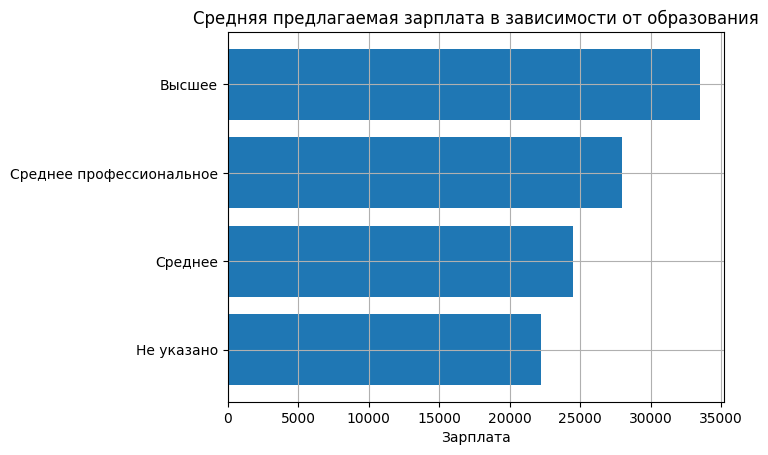

In [31]:
data.loc[:, 'education'] = data.loc[:, 'education'].replace(-1, 'Не указано', regex=True)
edu_study = data.groupby('education', as_index=False).agg({'id': 'count', 'salary_avg': 'mean'}).rename(columns={'id':'id_count'})\
    .sort_values(by='id_count',ascending=False)
display(edu_study)

edu_study = edu_study.sort_values(by='salary_avg',ascending=True)
edu_study = edu_study.query('id_count > 100')
edu_study_top = edu_study.tail(10)

fig, ax = plt.subplots()
ax.barh(edu_study_top['education'], edu_study_top['salary_avg'])
plt.title('Средняя предлагаемая зарплата в зависимости от образования')
plt.xlabel('Зарплата')
ax.grid()
plt.show()

Средняя предлагаемая заработная платиа для вакансий с высшим образованием составляет 33506 рублей. Для соискателей со средним специальным образованием  - почти 27937 рублей, соискатели со средним образованием могут рассчитывать на среднюю зарплату в 24468 рублей. Вакансии, где не указано в требовании наличие образования в среднем предлагают 22249 рублей.

### Средняя предлагаемая зарплата в организациях различного размера

,company_business_size,id_count,salary_avg
4,SMALL,7906,29088.907262
1,LARGE,566,33607.706714
2,MICRO,230,30055.004348
3,MIDDLE,228,28843.504386
0,BIG,186,28723.532258


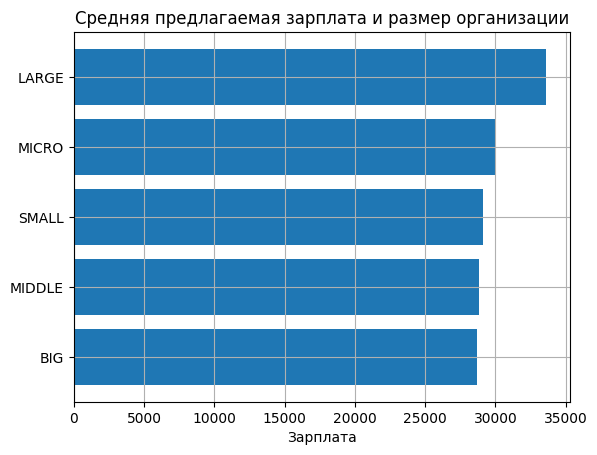

In [32]:
large_comp = data.groupby('company_business_size', as_index=False).agg({'id': 'count', 'salary_avg': 'mean'}).rename(columns={'id':'id_count'})\
    .sort_values(by='id_count',ascending=False)
display(large_comp)

large_comp = large_comp.sort_values(by='salary_avg',ascending=True)
large_comp = large_comp.query('id_count > 100')
large_comp_top = large_comp.tail(10)

fig, ax = plt.subplots()
ax.barh(large_comp_top['company_business_size'], large_comp_top['salary_avg'])
plt.title('Средняя предлагаемая зарплата и размер организации')
plt.xlabel('Зарплата')
ax.grid()
plt.show()

## Общий вывод по работе:

В работе был проанализирован рынок вакансий г. Краснодара портала Работа России на момент 30 декабря 2022 г.<br>
Основные выводы:<ul>
    <li>Всего представлено 9116 вакансий;</li>
    <li>Наиболее распространённый предлагаемый зарплатный "грейд": 15000-19999 рублей</li>
    <li>Больше всего вакансий предлагается в следующих сферах: производство (2638 вакансий), образование и наука (1456), здравохранение и социальное обеспечение (904). На эти сферы приходится 54% всех вакансий;</li>
    <li>Наибольшая средняя предлагаемая зарплата приходится на следующие сферы: государственная служба и НКО 57811 рублей, Информационные технологии и связь 44523 рубля, добывающая промышленность 42168 рублей;</li>
    <li>51,6% вакансий не требуют опыта работы;</li>
    <li>Самая высокая средняя предлагаемая зарплата для соискателей без работы приходится на сферы: строительство 34305 рублей, транспорт 29938 рублей, продажи 28963 рублей.</li>
    </ul>

## Выгрузка исследования для построения дашборда

In [33]:
data_dash = data[['id', 'salary_avg', 'professionalSphereName', 'busy_type' , 'published_date', 'required_experience']]

In [34]:
data['required_experience'] = data['required_experience'].astype('int')

In [35]:
data_dash.to_csv (r'D:\Projects\data_dash.csv', index = False )

Простой дашборд по этой работе доступен по <a href='https://public.tableau.com/app/profile/vasily3456/viz/DashbordWork/sheet4#2'>ссылке</a>.